In this notebook, useful data loading and transforming functions are demonstrated.  The main sources of data are Quandl, Cryptocompare and Yahoo Finance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pickle
import itertools
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import quandl

In [3]:
from utils import *

# Quandl

In [4]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

## Exchange Data International

One may use [_Exchange Data International_](https://www.quandl.com/publishers/edi) free sample series as follows:

In [5]:
print(os.listdir(QUANDL_PATH))

['XSHE.csv', 'XSHG.csv', 'XNAS.pickle', 'XSES.csv', 'XHKG.pickle', 'SCF.csv', 'XASE.csv', 'XTSE.pickle', 'XSES.pickle', 'XBOM.csv', 'XASE.pickle', 'XTSX.csv', 'XLON.csv', 'XSHG.pickle', 'XNAS.csv', 'XTSE.csv', 'XTSX.pickle', 'XBOM.pickle', 'XNYS.csv', 'XSHE.pickle', 'XNSE.pickle', 'SHARADAR-TICKERS.csv', 'XJPX.pickle', 'XNYS.pickle', 'CUR.txt', 'sharadar_full.csv', 'XLON.pickle', 'XJPX.csv', 'XHKG.csv', 'XNSE.csv']


In [6]:
# tickers, prices = get_quandl_edi(get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys())), download=True)  # The first time...
tickers, prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))

In [7]:
prices

Open         High          Low        Close  \
Ticker     Date                                                             
XNAS/AAXJ  2008-08-15    42.372604    42.372604    42.372604    42.372604   
           2008-08-18    42.068312    42.068312    41.417466    41.417466   
           2008-08-19    40.859598    40.859598    40.859598    40.859598   
           2008-08-20    41.459729    41.459729    41.434371    41.434371   
           2008-08-21    41.459729    41.459729    41.434371    41.434371   
...                            ...          ...          ...          ...   
XJPX/13760 2018-06-07  1589.000000  1610.000000  1586.000000  1610.000000   
           2018-06-08  1593.000000  1613.000000  1593.000000  1609.000000   
           2018-06-11  1590.000000  1603.000000  1584.000000  1599.000000   
           2018-06-12  1599.000000  1615.000000  1598.000000  1612.000000   
           2018-06-13  1608.000000  1615.000000  1608.000000  1615.000000   

                        Volume  
Ticker     Date                 
XNAS/AAXJ  2008-08-15    100.0  
           2008-08-18  25416.0  
           2008-08-19    100.0  
           2008-08-20   4000.0  
           2008-08-21      0.0  
...                        ...  
XJPX/13760 2018-06-07   2700.0  
           2018-06-08   8800.0  
           2018-06-11   4500.0  
           2018-06-12   2300.0  
           2018-06-13   2300.0  

[557075 rows x 5 columns]

In [8]:
print('Number of price series:', len(tickers))

Number of price series: 191


j: 4  -  XNAS/ACET


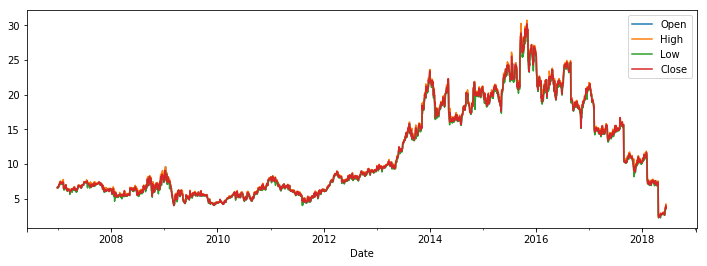

In [9]:
j = np.random.choice(len(tickers) - 1)
ticker_j = list(tickers)[j]
print('j:', j, ' - ', ticker_j)
price_j = prices.loc[ticker_j]
price_j[['Open', 'High', 'Low', 'Close']].plot();

In [10]:
price_j

,Open,High,Low,Close,Volume
Date,,,,,
2006-12-28,6.577988,6.624585,6.539157,6.562455,14052.0
2006-12-29,6.585754,6.710013,6.562455,6.710013,18612.0
2007-01-01,6.710013,6.710013,6.710013,6.710013,0.0
2007-01-02,6.710013,6.710013,6.710013,6.710013,0.0
2007-01-03,6.733312,6.733312,6.577988,6.609053,68745.0
...,...,...,...,...,...
2018-06-07,3.340000,3.645000,3.260000,3.550000,176450.0
2018-06-08,3.520000,3.665000,3.400000,3.640000,128581.0
2018-06-11,3.640000,4.010000,3.640000,3.980000,182165.0


##  Sharadar Equity Prices

One may use [_Sharadar Equity Prices_](https://www.quandl.com/publishers/sharadar) free sample series as follows:

In [11]:
# tickers, prices = get_quandl_sharadar(download=True)  # The first time...
tickers, prices = get_quandl_sharadar(download=True)

In [12]:
print('Number of price series:', len(tickers))

Number of price series: 30


In [16]:
prices

,,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated
Ticker,Date,,,,,,,,
AAPL,1998-12-31,1.446,1.478,1.411,1.462,67922400.0,0.00,40.94,2018-06-19
AXP,1998-12-31,34.967,35.100,34.100,34.167,2528700.0,0.00,102.50,2018-02-11
BA,1998-12-31,31.750,33.130,31.630,32.630,7343500.0,0.00,32.63,2018-02-11
CAT,1998-12-31,23.000,23.940,23.000,23.000,4147400.0,0.00,46.00,2018-02-11
CSCO,1998-12-31,23.220,23.500,22.953,23.250,29021600.0,0.00,93.00,2018-02-11
...,...,...,...,...,...,...,...,...,...
UNH,2018-07-09,252.130,254.010,251.050,253.670,2017318.0,0.00,253.67,2018-07-09
UTX,2018-07-09,126.010,126.990,125.810,126.680,3291148.0,0.00,126.68,2018-07-09
VZ,2018-07-09,51.030,51.110,50.680,50.740,10438936.0,0.59,50.74,2018-07-09


j: 8  -  CSCO


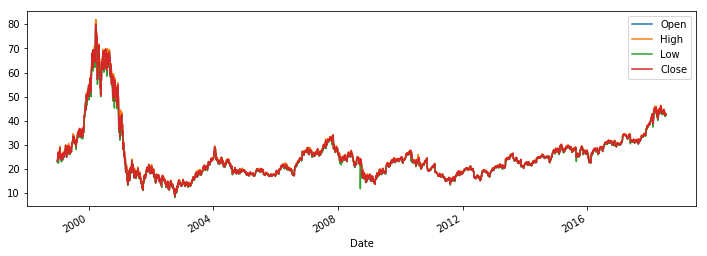

In [13]:
j = np.random.choice(len(tickers) - 1)
ticker_j = list(tickers)[j]
print('j:', j, ' - ', ticker_j)
price_j = get_price_j(ticker_j, prices)
price_j[['Open', 'High', 'Low', 'Close']].plot();

In [14]:
price_j

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated
Date,,,,,,,,
1998-12-31,23.220,23.500,22.953,23.250,29021600.0,0.00,93.00,2018-02-11
1999-01-04,23.625,24.157,23.345,23.828,62691200.0,0.00,95.31,2018-02-11
1999-01-05,23.953,24.282,23.720,24.235,50396000.0,0.00,96.94,2018-02-11
1999-01-06,24.970,25.375,24.750,24.938,81818000.0,0.00,99.75,2018-02-11
1999-01-07,24.625,26.250,24.515,25.900,95150800.0,0.00,103.60,2018-02-11
...,...,...,...,...,...,...,...,...
2018-07-02,42.560,42.830,42.200,42.810,21319731.0,0.00,42.81,2018-07-02
2018-07-03,42.935,43.225,42.620,42.670,13465999.0,0.00,42.67,2018-07-03
2018-07-05,42.560,42.640,41.960,42.560,17371163.0,0.33,42.56,2018-07-05


### Metadata...

In [38]:
shr_meta = pd.read_csv('input/Quandl/SHARADAR-TICKERS.csv')
shr_meta.to_excel('input/Quandl/SHARADAR-TICKERS.xlsx')
shr_meta.keys()

Index(['table', 'permaticker', 'ticker', 'name', 'exchange', 'isdelisted',
       'category', 'cusips', 'siccode', 'sicsector', 'sicindustry',
       'famasector', 'famaindustry', 'sector', 'industry', 'scalemarketcap',
       'scalerevenue', 'relatedtickers', 'currency', 'location', 'lastupdated',
       'firstadded', 'firstpricedate', 'lastpricedate', 'firstquarter',
       'lastquarter', 'secfilings', 'companysite'],
      dtype='object')

In [29]:
shr_meta.describe(include=np.object)

,table,ticker,name,exchange,isdelisted,category,cusips,sicsector,sicindustry,famaindustry,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
count,10000,10000,10000,10000,10000,10000,9536,9967,9967,9966,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,5023
unique,1,10000,9904,5,2,3,9536,11,431,45,...,29,129,311,725,4281,2560,103,83,9919,5013
top,SF1,CE,CIT GROUP INC,NASDAQ,N,Domestic,420476103 301309100,Technology,PHARMACEUTICAL PREPARATIONS,Business Services,...,USD,CALIFORNIA U.S.A,2018-05-10,2014-09-30,1986-01-01,2018-07-09,1997-12-31,2018-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.gpreinc.com
freq,10000,1,3,5733,5215,8977,1,1763,582,1388,...,9498,1528,437,121,1062,4753,2891,4446,3,2


In [36]:
shr_meta.groupby('currency').count()

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,...,relatedtickers,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
currency,,,,,,,,,,,,,,,,,,,,,
ARS,9,9,9,9,9,9,9,9,9,9,...,0,9,9,9,9,9,9,9,9,9
AUD,14,14,14,14,14,14,14,8,14,13,...,6,14,14,14,14,14,14,14,14,7
BRL,27,27,27,27,27,27,27,26,27,26,...,3,27,27,27,27,27,27,27,27,23
CAD,126,126,126,126,126,126,126,117,126,126,...,31,126,126,126,126,126,126,126,126,73
CHF,5,5,5,5,5,5,5,5,5,5,...,1,5,5,5,5,5,5,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEK,7,7,7,7,7,7,7,6,7,7,...,3,7,7,7,7,7,7,7,7,2
TRY,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
TWD,7,7,7,7,7,7,7,6,7,7,...,1,7,7,7,7,7,7,7,7,5


### Train, Dev, Test samples 

In [17]:
N = len(tickers)
train, dev = 6 * N // 10, 2 * N // 10
test = N - train - dev
print('N:', N, ', Tain:', train, ', Dev:', dev, ', Test:', test)

N: 30 , Tain: 18 , Dev: 6 , Test: 6


In [18]:
np.random.seed(123)
tickers_full = list(np.random.permutation(tickers))
tickers_train = tickers_full[:train]
tickers_dev = tickers_full[train:(train + dev)]
tickers_test = tickers_full[-test:]
assert len(tickers_train + tickers_dev + tickers_test) == N

In [19]:
prices_train = prices.loc[tickers_train]
prices_train.reset_index().to_feather(fname='input/Quandl/sharadar_train.feather')

In [20]:
prices_dev = prices.loc[tickers_dev]
prices_dev.reset_index().to_feather(fname='input/Quandl/sharadar_dev.feather')

In [22]:
prices_test = prices.loc[tickers_test]
prices_test.reset_index().to_feather(fname='input/Quandl/sharadar_test.feather')

## Cryptocompare

## Yahoo Finance

## Data pre-processing 

# Data Cleaning

* OHLC: open and close within [low, high].

## Data Transforms

* Weekly and monthly OHLC prices.
* Zero volume days.
* Returns.
* Technical Indicators (volatility, skewness, etc.)

In [ ]:
weekly_j = daily_to_weekly_prices(price_j)

In [ ]:
weekly_j[['Open', 'High', 'Low', 'Close']].plot();